In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tqdm import tqdm
import re
import scipy
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Flatten, Embedding, Reshape, Multiply, Dropout, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GRU, LSTM
from tensorflow.keras.layers import Dot, TimeDistributed, BatchNormalization, Add, multiply
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
from sklearn.utils import shuffle
import seaborn as sns
import math
import collections
from collections import Counter
import matplotlib.pyplot as plt
import random

In [3]:
import gensim
from gensim.models import KeyedVectors

In [5]:
word2vec = KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

In [6]:
SEED=42

In [7]:
PATH = "../data/mind_small/"
news = pd.read_csv(PATH + "news.tsv",header=None, sep="\t")
behaviors = pd.read_csv(PATH + "behaviors.tsv", header=None, sep="\t")
news.columns = ["news_id", "category", "sub_category", "title", "abstract", "url", "title_entities", "abstract_entities"]
behaviors.columns = ["idx", "user_id", "time", "history", "impressions"]
behaviors = behaviors.drop_duplicates(["user_id", "history"]) 
behaviors.dropna(subset=["user_id", "history"], inplace=True)

In [8]:
sessions = {}
for idx, row in behaviors.iterrows():
    sessions[row["user_id"]] = row["history"].split(" ")

users = []
clicks = []
for k, v in sessions.items():
    for elem in v:
        users.append(k)
        clicks.append(elem)

tuples = list(zip(users, clicks))
interactions = pd.DataFrame(tuples, columns=["user", "news_id"])
interactions = interactions[:10000]

In [9]:
merged = interactions.merge(news, on=["news_id"])
merged.head(1)

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities
0,U13740,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."


In [10]:
print(len(merged))
merged = merged.drop_duplicates()
print(len(merged))

10000
9861


In [11]:
merged.dropna(subset=["abstract"], inplace=True)

# 1. Preprocessing

In [12]:
# remove users which have fewer than 5 interacations
print("Len before removal: ",len(merged))
_keys = merged["user"].value_counts()[merged["user"].value_counts() > 5].keys()
merged = merged[merged["user"].isin(_keys)]
print("Len after removal: ",len(merged))


user_enc = LabelEncoder()
article_enc = LabelEncoder()
merged["user_id"] = user_enc.fit_transform(merged["user"].values)
merged["article_id"] = article_enc.fit_transform(merged["news_id"].values)

Len before removal:  9554
Len after removal:  9426


In [13]:
def hyphen_to_underline(category):
    """
    Convert hyphen to underline for the subcategories. So that Tfidf works correctly
    """
    return category.replace("-","_")
merged["subcategory_cleaned"] = merged["sub_category"].apply(func = hyphen_to_underline)

In [14]:
category_enc = LabelEncoder()
subcategory_enc = LabelEncoder()
merged["subcategory_int"] = subcategory_enc.fit_transform(merged["subcategory_cleaned"].values)
merged["category_int"] = subcategory_enc.fit_transform(merged["category"].values)

In [15]:
users = merged["user_id"].unique()
userid_to_profile = collections.defaultdict(list)
for user_id in tqdm(users):
    user_subcat = merged[merged["user_id"] == user_id]["subcategory_int"].values.tolist()
    counter = Counter(user_subcat)
    s = sorted(user_subcat, key=lambda x: (counter[x], x), reverse=True)
    final_subcategories = []
    for elem in s:
        if elem not in final_subcategories:
            final_subcategories.append(elem)
    while len(final_subcategories) < 6:
        final_subcategories.append(0)
    userid_to_profile[user_id] = final_subcategories[:6]

100%|██████████| 231/231 [00:00<00:00, 1450.58it/s]


In [16]:
profile_df = pd.DataFrame.from_dict(userid_to_profile, orient="index")
profile_df["user_id"] = profile_df.index
merged = merged.merge(profile_df, on="user_id")
merged = merged.rename(columns={"0": "p0","1": "p1","2": "p2","3": "p3","4": "p4","5": "p5",})

article_id_to_category_int = merged[["article_id", "category_int"]].set_index("article_id").to_dict()
article_id_to_category_int = article_id_to_category_int["category_int"]

article_id_to_subcategory_int = merged[["article_id", "subcategory_int"]].set_index("article_id").to_dict()
article_id_to_subcategory_int = article_id_to_subcategory_int["subcategory_int"]

## 1.1 Text preprocessing

In [17]:
import nltk
from nltk.corpus import stopwords
# Helper functions
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def text_to_list(text):
    text = text.split(" ")
    return text

In [18]:
def clean_title(df):
    df["title_cleaned"] = df.title.apply(func = make_lower_case)
    #df["title_cleaned"] = df.title_cleaned.apply(func = remove_stop_words)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_punctuation)
    df["title_cleaned"] = df.title_cleaned.apply(func = _removeNonAscii)
    return df
def clean_abstract(df):
    df["abstract_cleaned"] = df.abstract.apply(func = make_lower_case)
    #df["abstract_cleaned"] = df.abstract_cleaned.apply(func = remove_stop_words)
    df["abstract_cleaned"] = df.abstract_cleaned.apply(func = remove_punctuation)
    df["abstract_cleaned"] = df.abstract_cleaned.apply(func = _removeNonAscii)
    return df

merged = clean_title(merged)
merged = clean_abstract(merged)


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAXLEN_TITLE = 20
MAXLEN_ABSTRACT = 30
oov_tok = "<UNK>"

In [20]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(merged["abstract_cleaned"].values)
temp = tokenizer.texts_to_sequences(merged["title_cleaned"].values)
temp = pad_sequences(temp, padding="post", maxlen=MAXLEN_TITLE)
merged["title_tokenized"] = temp.tolist()

temp = tokenizer.texts_to_sequences(merged["abstract_cleaned"].values)
temp = pad_sequences(temp, padding="post", maxlen=MAXLEN_TITLE)
merged["abstract_tokenized"] = temp.tolist()

In [21]:
word_index = tokenizer.word_index
for i,w in enumerate(word_index):
    print(w, word_index.get(w))
    if i == 4:
        break

<UNK> 1
the 2
a 3
to 4
of 5


In [22]:
VOCABSIZE = len(tokenizer.word_index)

In [23]:
VOCABSIZE

16661

In [24]:
article_to_title = merged[["article_id", "title_tokenized"]].set_index("article_id").to_dict()["title_tokenized"]
article_to_category = merged[["article_id", "category_int"]].set_index("article_id").to_dict()["category_int"]
article_to_subcategory = merged[["article_id", "subcategory_int"]].set_index("article_id").to_dict()["subcategory_int"]
article_to_abstract = merged[["article_id", "abstract_tokenized"]].set_index("article_id").to_dict()["abstract_tokenized"]

# 2. Train test split

In [25]:
def train_test_split(df, user_id, article_id, have_timestamp, timestamp):
    """
    params: 
        col_1: user_id
        col_2: article_id
    """
    df_test = df
    if have_timestamp: # if df have timestamp; take last interacted article into test set
        df_test = df_test.sort_values(timestamp).groupby(user_id).tail(1)
    else:
        df_test = df_test.sort_values(user_id).groupby(user_id).tail(1)
    df_train = df.drop(index=df_test.index)
    
    assert df_test.shape[0] + df_train.shape[0] == df.shape[0]
    
    return df_train, df_test
df_train_true, df_test_true = train_test_split(merged, "user_id", "article_id", False, 0)

In [26]:
def get_userid_to_article_history(df):
    userid_to_article_history = {}
    for user_id in tqdm(df["user_id"].unique()):
        click_history = df[df["user_id"] == user_id]["article_id"].values
        if len(click_history) < 10:
            while len(click_history) < 10:
                click_history = np.append(click_history, 0)
        if len(click_history) > 10:
            click_history = click_history[:10]
        userid_to_article_history[user_id] = click_history
    return userid_to_article_history
userid_to_article_history = get_userid_to_article_history(df_train_true)

100%|██████████| 231/231 [00:00<00:00, 1478.14it/s]


In [27]:
all_article_ids = merged["article_id"].unique()

def negative_sampling(train_df, all_article_ids, user_id, article_id):
    """
    Negative sample training instance; for each positive instance, add 4 negative articles
    
    Return user_ids, news_ids, category_1, category_2, authors_onehotencoded, titles
    """
    
    user_ids, user_click_history, articles, article_category, article_sub_category,titles,abstract, labels = [],[],[], [], [], [], [], []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    user_item_set = set(zip(train_df[user_id], 
                            train_df[article_id]))
    num_negatives = 4

    for (u, i) in tqdm(user_item_set):
        user_ids.append(u)
        user_click_history.append(userid_to_article_history[u])
        profile = np.array(userid_to_profile[u])
        p0.append(profile[0])
        p1.append(profile[1])
        p2.append(profile[2])
        p3.append(profile[3])
        p4.append(profile[4])
        p5.append(profile[5])
        article_category.append(article_id_to_category_int[i])
        article_sub_category.append(article_id_to_subcategory_int[i])
        titles.append(article_to_title[i])
        abstract.append(article_to_abstract[i])
        
        for _ in range(num_negatives):
            negative_item = np.random.choice(all_article_ids)
            while (u, negative_item) in user_item_set:
                negative_item = np.random.choice(all_article_ids)
            user_ids.append(u)
            user_click_history.append(userid_to_article_history[u])
            p0.append(profile[0])
            p1.append(profile[1])
            p2.append(profile[2])
            p3.append(profile[3])
            p4.append(profile[4])
            p5.append(profile[5])
            
            article_category.append(article_id_to_category_int[negative_item])
            article_sub_category.append(article_id_to_subcategory_int[negative_item])
            titles.append(article_to_title[negative_item])
            abstract.append(article_to_abstract[negative_item])
            
            articles.append(negative_item)
            labels.append(0)
        articles.append(i)
        labels.append(1)
    
    user_ids, user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category,titles,abstract, labels = shuffle(user_ids,user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category,titles,abstract, labels, random_state=0)

    return pd.DataFrame(list(zip(user_ids,user_click_history,p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category,titles,abstract, labels)), columns=["user_id","user_history","p0", "p1", "p2", "p3", "p4", "p5", "article_id","article_category","article_sub_category","titles","abstract", "labels"])



df_train = negative_sampling(df_train_true, all_article_ids, "user_id", "article_id")

100%|██████████| 9195/9195 [00:00<00:00, 24244.50it/s]


In [28]:
def fix_dftrain(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

#df_train = fix_dftrain(df_train, "user_history", 10, 0)
#df_train.drop(columns=["user_history"], inplace=True)
#df_train.head()

In [54]:
# For each user; for each item the user has interacted with in the test set;
    # Sample 99 items the user has not interacted with in the past and add the one test item  
    
def negative_sample_testset(ordiginal_df, df_test, all_article_ids, user_id, article_id):
    test_user_item_set = set(zip(df_test[user_id], df_test[article_id]))
    user_interacted_items = ordiginal_df.groupby(user_id)[article_id].apply(list).to_dict()
    users = []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    res_arr = []
    article_category, article_sub_category = [], []
    
    userid_to_true_item = {} # keep track of the real items
    for (u,i) in tqdm(test_user_item_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(all_article_ids) - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = [i]+selected_not_interacted 
        temp = []
        profile = userid_to_profile[u]
        for j in range(len(test_items)):
            temp.append([u,
                         userid_to_article_history[u], 
                         profile[0],
                         profile[1],
                         profile[2],
                         profile[3],
                         profile[4],
                         profile[5], 
                         test_items[j], 
                         article_id_to_category_int[test_items[j]],
                         article_id_to_subcategory_int[test_items[j]], 
                         article_to_title[test_items[j]],
                         article_to_abstract[test_items[j]]
                        ])
        #            user_click_history.append(userid_to_article_history[u])

        res_arr.append(temp)
        userid_to_true_item[u] = i 
    X_test = np.array(res_arr)
    X_test = X_test.reshape(-1, X_test.shape[-1])
    df_test = pd.DataFrame(X_test, columns=["user_id",
                                            "click_history", 
                                            "p0", 
                                            "p1", 
                                            "p2", 
                                            "p3", 
                                            "p4", 
                                            "p5",
                                            "article_id", 
                                            "category", 
                                            "sub_category",
                                            "title",
                                            "abstract"])
    return X_test, df_test, userid_to_true_item
X_test, df_test, userid_to_true_item = negative_sample_testset(merged, df_test_true, merged["article_id"].unique(), "user_id", "article_id")
    
    

100%|██████████| 231/231 [00:00<00:00, 613.69it/s]
/Users/eivindfalun/opt/anaconda3/envs/shapRs/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [30]:
def fix_dftest(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

#df_test = fix_dftest(df_test, "click_history", 10, 0)
#df_test.drop(columns=["click_history"], inplace=True)

In [31]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

# 4. Model


In [32]:
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique())
num_categories = len(merged["category_int"].unique()) 
num_sub_categories = len(merged["subcategory_int"].unique())

dims = 20
def get_model_neumfonefeat(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    
    mf_user_emb = Embedding(output_dim=dims, 
                            input_dim=num_users, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=dims, 
                            input_dim=num_items, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    mlp_user_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_users, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                             embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_emb")(user_input)
    mlp_item_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_items, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_item")(item_input)
    
    # Matrix factorization
    mf_user_vecs = Reshape([dims])(mf_user_emb)
    mf_item_vecs = Reshape([dims])(mf_item_emb)
    
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    #MLP
    category_input = Input(shape=(1,), name="category_input")
    
    item_category_emb = Embedding(input_dim=num_categories, output_dim=int(dense_layers[0] / 2), name="category_emd", embeddings_regularizer=regularizers.l2(0.001))(category_input)

    item_category_flatten = Flatten()(item_category_emb)
    user_flatten = Flatten()(mlp_user_emb)
    item_flatten = Flatten()(mlp_item_emb)
    
    
    wide_features = Concatenate()([item_category_flatten,user_flatten, item_flatten])
    mlp_vector = Flatten()(wide_features)
    for num_dense in dense_layers:
        l = Dense(num_dense, activation="relu")
        mlp_vector = l(mlp_vector)
        mlp_vector = Dropout(0.2)(mlp_vector)
    

    
    mlp_vec = Concatenate()([mlp_user_emb, mlp_item_emb])
    mlp_vector = Flatten()(mlp_vec)
    
    y = Concatenate()([mf_vec, mlp_vector])
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input, item_input,category_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumf_one_feat = get_model_neumfonefeat(num_users, num_items, dims)

In [ ]:
###### Training ########
user_input = df_train.user_id.values
articles = df_train.article_id.values
category = df_train.article_category.values
labels = df_train.labels.values
epochs = 3
for epoch in range(epochs):
    hist = model_neumf_one_feat.fit([user_input,articles,category], labels, validation_split=0.1, epochs=1, shuffle=True)

In [ ]:
test_users = df_test.user_id.unique()[:100]
test_users = shuffle(test_users)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
h_ten, h_five, n_ten, n_five = [], [], [], []
for user_id in tqdm(test_users):
    user_df = df_test[df_test["user_id"] == user_id ]
    users = np.array([user_id]*100).reshape(-1,1).astype(int)
    items = user_df.article_id.values.reshape(-1,1).astype(int)
    categories = user_df.category.values.reshape(-1,1).astype(int)
    
    true_item = userid_to_true_item[user_id]
    
    predictions = model_neumf_one_feat.predict([users, items,categories])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    h_ten.append(getHitRatio(top_ten_items, true_item))
    h_five.append(getHitRatio(top_ten_items[:5], true_item))
    n_ten.append(getNDCG(top_ten_items, true_item))
    n_five.append(getNDCG(top_ten_items[:5], true_item))

In [ ]:
print(np.average(h_ten))
print(np.average(h_five))
print(np.average(n_ten))
print(np.average(n_five))

# 4.2 With title and abstract

In [ ]:
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique())
num_categories = len(merged["category_int"].unique()) 
num_sub_categories = len(merged["subcategory_int"].unique())

dims = 20
def get_model_neumfonefeat(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    title_input = Input(shape=(MAXLEN_TITLE,), name="title")
    category_input = Input(shape=(1,), name="category_input")

    
    mf_user_emb = Embedding(output_dim=dims, 
                            input_dim=num_users, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=dims, 
                            input_dim=num_items, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    mlp_user_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_users, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                             embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_emb")(user_input)
    mlp_item_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                             input_dim=num_items, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                             name="mlp_user_item")(item_input)
    
    title_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                          embeddings_initializer='he_normal', 
                          embeddings_regularizer=regularizers.l2(0.001),
                          input_dim=VOCABSIZE,
                          input_length=MAXLEN_TITLE,
                          name="title_em")(title_input)
    item_category_emb = Embedding(input_dim=num_categories, 
                                  output_dim=int(dense_layers[0] / 2), 
                                  name="category_emd", 
                                  embeddings_regularizer=regularizers.l2(0.001))(category_input)

    
    # Matrix factorization
    mf_user_vecs = Reshape([dims])(mf_user_emb)
    mf_item_vecs = Reshape([dims])(mf_item_emb)
    
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    #MLP
    item_category_flatten = Flatten()(item_category_emb)
    user_flatten = Flatten()(mlp_user_emb)
    item_flatten = Flatten()(mlp_item_emb)
    title_flatten = Flatten()(title_emb)
    
    
    wide_features = Concatenate()([item_category_flatten,title_flatten])
    mlp_vector = Flatten()(wide_features)
    for num_dense in dense_layers:
        l = Dense(num_dense, activation="relu")
        mlp_vector = l(mlp_vector)
        mlp_vector = Dropout(0.2)(mlp_vector)
    

    
    mlp_vec = Concatenate()([mlp_user_emb, mlp_item_emb])
    mlp_vector = Flatten()(mlp_vec)
    
    y = Concatenate()([mf_vec, mlp_vector])
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input, item_input,category_input, title_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumf_one_feat = get_model_neumfonefeat(num_users, num_items, dims)

In [ ]:
###### Training ########
user_input = df_train.user_id.values
articles = df_train.article_id.values
category = df_train.article_category.values
titles = np.array([np.array(t) for t in df_train.titles.values])
labels = df_train.labels.values
epochs = 3
for epoch in range(epochs):
    hist = model_neumf_one_feat.fit([user_input,articles,category, titles], labels, validation_split=0.1, epochs=1, shuffle=True)

In [ ]:
test_users = df_test.user_id.unique()[:100]
test_users = shuffle(test_users)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
h_ten, h_five, n_ten, n_five = [], [], [], []
for user_id in tqdm(test_users):
    user_df = df_test[df_test["user_id"] == user_id ]
    users = np.array([user_id]*100).reshape(-1,1).astype(int)
    items = user_df.article_id.values.reshape(-1,1).astype(int)
    categories = user_df.category.values.reshape(-1,1).astype(int)
    titles = np.array([np.array(t) for t in user_df.title.values])
    true_item = userid_to_true_item[user_id]
    
    predictions = model_neumf_one_feat.predict([users, items,categories,titles])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    h_ten.append(getHitRatio(top_ten_items, true_item))
    h_five.append(getHitRatio(top_ten_items[:5], true_item))
    n_ten.append(getNDCG(top_ten_items, true_item))
    n_five.append(getNDCG(top_ten_items[:5], true_item))

In [ ]:
print(np.average(h_ten))
print(np.average(h_five))
print(np.average(n_ten))
print(np.average(n_five))

# 4.3 With GRU

In [75]:
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique())
num_categories = len(merged["category_int"].unique()) 
num_sub_categories = len(merged["subcategory_int"].unique())

dims = 20
def get_model_neumfonefeat(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    title_input = Input(shape=(MAXLEN_TITLE,), name="title")

    
    mf_user_emb = Embedding(output_dim=dims, 
                            input_dim=num_users, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=dims, 
                            input_dim=num_items, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    
    title_emb = Embedding(output_dim=int(dense_layers[0] / 2), 
                          embeddings_initializer='he_normal', 
                          embeddings_regularizer=regularizers.l2(0.001),
                          input_dim=VOCABSIZE,
                          input_length=MAXLEN_TITLE,
                          name="title_em")(title_input)
    
    # Matrix factorization
    mf_user_vecs = Reshape([dims])(mf_user_emb)
    mf_item_vecs = Reshape([dims])(mf_item_emb)
    
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    nlp_gru = layers.Bidirectional(layers.GRU(64))(title_emb)
    nlp_gru = Dropout(0.5)(nlp_gru)
    nlp_l = Dense(units=dense_layers[-1], activation="relu")(nlp_gru)
    
    y = Concatenate()([mf_vec, nlp_l])
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input, item_input, title_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumf_one_feat = get_model_neumfonefeat(num_users, num_items, dims)

In [76]:
###### Training ########
train_loss = []
val_loss = []

user_input = df_train.user_id.values
articles = df_train.article_id.values
category = df_train.article_category.values
titles = np.array([np.array(t) for t in df_train.titles.values])
labels = df_train.labels.values
epochs = 3
for epoch in range(epochs):
    hist = model_neumf_one_feat.fit([user_input,articles, titles], labels, validation_split=0.1, epochs=1, shuffle=True)
    train_loss.append(hist.history["loss"])
    val_loss.append(hist.history["val_loss"])

 184/1294 [===>..........................] - ETA: 21s - loss: 0.5603 - accuracy: 0.7858

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc1_loss.pdf")
plt.show()

In [ ]:
test_users = df_test.user_id.unique()[:100]
test_users = shuffle(test_users)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
h_ten, h_five, n_ten, n_five = [], [], [], []
for user_id in tqdm(test_users):
    user_df = df_test[df_test["user_id"] == user_id ]
    users = np.array([user_id]*100).reshape(-1,1).astype(int)
    items = user_df.article_id.values.reshape(-1,1).astype(int)
    categories = user_df.category.values.reshape(-1,1).astype(int)
    titles = np.array([np.array(t) for t in user_df.title.values])
    true_item = userid_to_true_item[user_id]
    
    predictions = model_neumf_one_feat.predict([users, items,categories,titles])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    h_ten.append(getHitRatio(top_ten_items, true_item))
    h_five.append(getHitRatio(top_ten_items[:5], true_item))
    n_ten.append(getNDCG(top_ten_items, true_item))
    n_five.append(getNDCG(top_ten_items[:5], true_item))

In [49]:
print(np.average(h_ten))
print(np.average(h_five))
print(np.average(n_ten))
print(np.average(n_five))

NameError: name 'h_ten' is not defined

# 4.4 GRU and pretrained

In [35]:
emb_mean = word2vec.vectors.mean()
emb_std = word2vec.vectors.std()
def pretrained_embedding(word_to_vec_map, word_to_index, emb_mean=emb_mean, emb_std=emb_std):
    vocab_size = len(word_to_index) +1
    dim = 300
    emb_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, dim))
    for word, idx in word_to_index.items():
        if word in word_to_vec_map:
            emb_matrix[idx] = word_to_vec_map.get_vector(word)
    return emb_matrix

In [65]:
w_2_i = {'<UNK>': 1, 'handsome': 2, 'cool': 3, 'shit': 4 }
em_matrix = pretrained_embedding(word2vec, w_2_i, emb_mean, emb_std)
em_matrix


array([[-8.70014913e-02, -9.18391838e-02, -1.77472309e-03, ...,
        -1.10702844e-01, -1.72918968e-01,  2.41375966e-04],
       [-2.18610361e-02, -4.23943528e-02,  1.52016608e-02, ...,
         2.92319327e-01, -9.90438607e-02, -8.96336514e-02],
       [ 1.13769531e-01,  1.79687500e-01, -2.65625000e-01, ...,
        -2.18750000e-01, -3.93066406e-02,  2.09960938e-01],
       [ 1.64062500e-01,  1.87500000e-01, -4.10156250e-02, ...,
         1.08886719e-01, -1.01928711e-02,  2.07519531e-02],
       [ 1.08886719e-01, -1.66992188e-01,  8.98437500e-02, ...,
        -1.96289062e-01, -2.31445312e-01,  4.61425781e-02]])

In [66]:
emb_matrix = pretrained_embedding(word2vec, tokenizer.word_index)

In [67]:
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique())
num_categories = len(merged["category_int"].unique()) 
num_sub_categories = len(merged["subcategory_int"].unique())

dims = 20
def get_model_neumfonefeat(num_users, num_items, dims, emb_matrix=None):
    dense_layers=[128, 64, 32, 8]
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    title_input = Input(shape=(MAXLEN_TITLE,), name="title")

    
    mf_user_emb = Embedding(output_dim=dims, 
                            input_dim=num_users, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=dims, 
                            input_dim=num_items, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    
    title_emb = Embedding(output_dim=300, 
                          embeddings_initializer='he_normal', 
                          embeddings_regularizer=regularizers.l2(0.001),
                          input_dim=(VOCABSIZE +1),
                          input_length=MAXLEN_TITLE,
                          weights=[emb_matrix],
                          trainable=False,
                          name="title_em")(title_input)

    
    # Matrix factorization
    mf_user_vecs = Reshape([dims])(mf_user_emb)
    mf_item_vecs = Reshape([dims])(mf_item_emb)
    
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    # NLP
    nlp_gru = layers.Bidirectional(layers.GRU(64))(title_emb)
    nlp_gru = Dropout(0.5)(nlp_gru)
    nlp_l = Dense(units=dense_layers[-1], activation="relu")(nlp_gru)
    
    y = Concatenate()([mf_vec, nlp_l])
    y = Dense(8, activation="relu")(y)
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input, item_input, title_input], outputs=y)
    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumf_one_feat = get_model_neumfonefeat(num_users, num_items, dims, emb_matrix)

In [68]:
###### Training ########
train_loss = []
val_loss = []

user_input = df_train.user_id.values
articles = df_train.article_id.values
category = df_train.article_category.values
titles = np.array([np.array(t) for t in df_train.titles.values])
labels = df_train.labels.values
epochs = 3
for epoch in range(epochs):
    hist = model_neumf_one_feat.fit([user_input,articles, titles], labels, validation_split=0.1, epochs=1, shuffle=True, batch_size=256)
    train_loss.append(hist.history["loss"])
    val_loss.append(hist.history["val_loss"])

162/162 [==============================] - 9s 58ms/step - loss: 145.7198 - accuracy: 0.7998 - val_loss: 145.7196 - val_accuracy: 0.8017


In [70]:
test_users = df_test.user_id.unique()[:100]
test_users = shuffle(test_users)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
h_ten, h_five, n_ten, n_five = [], [], [], []
for user_id in tqdm(test_users):
    user_df = df_test[df_test["user_id"] == user_id ]
    users = np.array([user_id]*100).reshape(-1,1).astype(int)
    items = user_df.article_id.values.reshape(-1,1).astype(int)
    categories = user_df.category.values.reshape(-1,1).astype(int)
    titles = np.array([np.array(t) for t in user_df.title.values])
    true_item = userid_to_true_item[user_id]
    
    predictions = model_neumf_one_feat.predict([users, items,titles])
    predicted_labels = np.squeeze(predictions)
    print(predicted_labels)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    h_ten.append(getHitRatio(top_ten_items, true_item))
    h_five.append(getHitRatio(top_ten_items[:5], true_item))
    n_ten.append(getNDCG(top_ten_items, true_item))
    n_five.append(getNDCG(top_ten_items[:5], true_item))

  3%|▎         | 3/100 [00:00<00:18,  5.13it/s]

[0.2109156  0.23469836 0.22801405 0.20435879 0.20647413 0.19038263
 0.2124933  0.1971336  0.24560702 0.17146051 0.1839053  0.20571563
 0.17684314 0.20181182 0.20037958 0.16352507 0.18783864 0.19364524
 0.18782967 0.17660487 0.15802702 0.16816238 0.19906941 0.16636676
 0.18009913 0.21174386 0.20952311 0.23039362 0.15419263 0.17777756
 0.19317663 0.17381537 0.22606671 0.21403754 0.24528399 0.19214088
 0.24485412 0.2573408  0.22776076 0.24517587 0.2473096  0.24484277
 0.21516752 0.19650099 0.20408306 0.19984496 0.1821942  0.26140708
 0.20515472 0.1637403  0.19134632 0.20850715 0.25638518 0.24190971
 0.21143425 0.20269653 0.20528391 0.22101983 0.19406843 0.16473752
 0.19541138 0.18149525 0.14969295 0.20632362 0.22082841 0.17649105
 0.23105553 0.23088571 0.2452853  0.19582132 0.20524508 0.2317892
 0.26728243 0.19546863 0.20189056 0.2506022  0.18722662 0.21443164
 0.18611917 0.20638773 0.21518996 0.20385173 0.18508396 0.1904147
 0.24341378 0.18588135 0.18119827 0.21154138 0.2031171  0.173352

  7%|▋         | 7/100 [00:00<00:09,  9.75it/s]

[0.1872946  0.18359303 0.18609828 0.21484852 0.15868509 0.17755562
 0.2403261  0.24919656 0.18865457 0.24724787 0.20413795 0.1476573
 0.18987256 0.19863966 0.22606671 0.19839454 0.21044779 0.16734472
 0.21802875 0.22031483 0.20486459 0.18075967 0.16568947 0.21719831
 0.21701348 0.19592535 0.19249997 0.18283838 0.24560824 0.22089207
 0.20650396 0.15228963 0.20327225 0.1679864  0.18944961 0.18305084
 0.20141801 0.18287593 0.21409017 0.22532627 0.2257604  0.18854415
 0.1809215  0.24257383 0.18059063 0.19083959 0.19041884 0.15738785
 0.23788989 0.20266813 0.2610675  0.19374198 0.21479625 0.1679911
 0.19364524 0.23690826 0.20548296 0.19522393 0.18833622 0.21436659
 0.1883707  0.20031914 0.19896662 0.18772289 0.19953266 0.21482974
 0.19183746 0.20183143 0.21570474 0.16684961 0.20524508 0.1707888
 0.16449425 0.19113922 0.1969254  0.22173718 0.16993365 0.20790228
 0.15727091 0.21697807 0.21139956 0.20482582 0.20162538 0.19265315
 0.17649049 0.23844656 0.1687718  0.21291327 0.21434295 0.1895387

 11%|█         | 11/100 [00:01<00:07, 12.25it/s]

[0.1943343  0.17731872 0.2032311  0.21117187 0.22507861 0.2034752
 0.16788718 0.1754143  0.20078847 0.23726681 0.18053526 0.20462596
 0.18607002 0.20031914 0.22316408 0.22891203 0.21677288 0.20272875
 0.182816   0.19211188 0.18372083 0.2000562  0.17501983 0.20029905
 0.19607589 0.19399276 0.19357908 0.23425728 0.21530658 0.16353497
 0.19896662 0.21985179 0.19965741 0.1815834  0.17237088 0.14972636
 0.21777898 0.19014332 0.18977442 0.18809482 0.16911232 0.19404021
 0.24942708 0.22533852 0.20214194 0.18303394 0.16054335 0.20387474
 0.17754811 0.203433   0.17090419 0.21649057 0.21319425 0.23776132
 0.22003287 0.20125163 0.21066806 0.23457715 0.1899643  0.18342608
 0.23014653 0.2056131  0.20078817 0.2126351  0.21617353 0.1619327
 0.21736106 0.2268723  0.20865631 0.18372083 0.22266603 0.20606378
 0.24117747 0.18070558 0.1944952  0.17365608 0.22063598 0.17907032
 0.186216   0.2272138  0.20721963 0.19407439 0.19632125 0.19370934
 0.22830501 0.22924855 0.18403831 0.175329   0.19010076 0.213265

 15%|█▌        | 15/100 [00:01<00:06, 13.65it/s]

[0.17628604 0.2132093  0.23254707 0.20558861 0.16930133 0.1946938
 0.20922774 0.17553395 0.21009865 0.16285488 0.17905766 0.17765254
 0.18111414 0.22815993 0.19960326 0.17558336 0.16561198 0.20279723
 0.22397786 0.19990417 0.19432339 0.20149693 0.16537476 0.20007169
 0.21087793 0.21467534 0.15868509 0.1707888  0.22532627 0.2211324
 0.22077662 0.19003683 0.1968677  0.21374914 0.18961957 0.1821942
 0.22057086 0.20133021 0.2155531  0.19632125 0.18041164 0.17870468
 0.18221083 0.17779616 0.20200369 0.18861601 0.16999689 0.2011536
 0.17989954 0.20160744 0.2145834  0.16466674 0.17661512 0.22031483
 0.19791982 0.24179062 0.19526565 0.17494386 0.20731738 0.1900369
 0.21536303 0.20234385 0.21179667 0.20191038 0.2201784  0.2249577
 0.17169815 0.19600996 0.2109349  0.2077159  0.2472341  0.21788609
 0.21106368 0.21197987 0.22422162 0.15894675 0.21003476 0.18348771
 0.17469499 0.16895503 0.20315999 0.22522214 0.17732343 0.19700438
 0.22828043 0.18307093 0.2077159  0.1740503  0.18430522 0.2075597
 0

 19%|█▉        | 19/100 [00:01<00:05, 14.35it/s]

[0.2010203  0.21241826 0.18704757 0.2023252  0.19978145 0.20326239
 0.20398825 0.19249997 0.15894675 0.21439454 0.2147507  0.18693107
 0.19343314 0.19367439 0.18338919 0.26728243 0.18934849 0.20037958
 0.16823658 0.1805211  0.17649105 0.19857737 0.17186686 0.17587271
 0.19588766 0.18297288 0.21236527 0.18058965 0.17607272 0.21209064
 0.18359303 0.20444188 0.21790463 0.18675846 0.27694675 0.20888016
 0.17413786 0.21655056 0.20330107 0.1886903  0.18304422 0.21884793
 0.21516448 0.20192012 0.17862436 0.1892919  0.2221613  0.20865905
 0.22539645 0.18500549 0.18411782 0.16353497 0.16865933 0.18650317
 0.20078713 0.21673268 0.24537274 0.1948516  0.19163483 0.15648535
 0.16652921 0.15648535 0.20171455 0.1897744  0.2186903  0.18220535
 0.2156182  0.16577324 0.24724787 0.1989649  0.20194384 0.17413786
 0.19194153 0.18332136 0.18435684 0.18698087 0.15556124 0.19158721
 0.17883739 0.19370082 0.17975539 0.19250342 0.16680261 0.16128081
 0.22045505 0.14569217 0.20311555 0.18696705 0.19023743 0.1858

 23%|██▎       | 23/100 [00:02<00:05, 15.31it/s]

[0.16985944 0.23471043 0.23797223 0.22412077 0.21003476 0.19154954
 0.15224826 0.18708503 0.17385837 0.23238209 0.19001392 0.17104006
 0.1940932  0.21408623 0.1843391  0.21143886 0.19075868 0.20326239
 0.19163483 0.19512126 0.1781623  0.17123199 0.17943555 0.182816
 0.18135035 0.21169323 0.17802072 0.17783198 0.19296765 0.2145806
 0.17574677 0.1681385  0.17949432 0.20655602 0.17893088 0.21121982
 0.20720959 0.1985861  0.19154787 0.17031303 0.267448   0.19660938
 0.15369275 0.2127594  0.189046   0.2033098  0.20536801 0.21758738
 0.18575326 0.1948516  0.24767792 0.195826   0.17469168 0.19509882
 0.19329348 0.19852611 0.21819553 0.20176494 0.21681824 0.24257383
 0.19291046 0.22388497 0.2136282  0.19153264 0.18335783 0.21251673
 0.18934849 0.19367155 0.2032311  0.1615243  0.20738965 0.2012169
 0.17381537 0.22497818 0.18228486 0.19971138 0.16601282 0.23288447
 0.20737553 0.15758872 0.16715983 0.20309022 0.18627903 0.1881727
 0.21330142 0.17930883 0.18756127 0.24091929 0.19667092 0.2249577
 

 27%|██▋       | 27/100 [00:02<00:04, 15.44it/s]

[0.21179667 0.19966128 0.2638139  0.2524184  0.237816   0.21927747
 0.20748088 0.18541774 0.22329837 0.23543671 0.24984169 0.18476754
 0.19656345 0.17086318 0.23727816 0.189046   0.18633643 0.21428847
 0.25179145 0.23961222 0.20349628 0.19214088 0.16673908 0.20983317
 0.24187684 0.17381877 0.19197908 0.18155527 0.18144864 0.20464554
 0.26183844 0.20436788 0.2647053  0.16964489 0.1922383  0.15787125
 0.20190951 0.1991544  0.20022604 0.19113395 0.20283961 0.1991544
 0.18828881 0.24128044 0.25520223 0.20489746 0.21014199 0.15473014
 0.2459951  0.19823071 0.21169397 0.21760762 0.18620381 0.20775643
 0.18187952 0.17500612 0.17356777 0.17404571 0.23524567 0.19045582
 0.18212974 0.20331427 0.20910335 0.19035715 0.1814999  0.20332965
 0.20128053 0.1646907  0.23435083 0.20077449 0.22589007 0.14378878
 0.20076483 0.20320642 0.19970256 0.17358896 0.18179908 0.20313048
 0.17640474 0.19890714 0.19296274 0.21150279 0.20185792 0.18650317
 0.23488677 0.2260597  0.20456749 0.21098322 0.2594846  0.23553

 31%|███       | 31/100 [00:02<00:04, 15.74it/s]

[0.16632974 0.16568947 0.2188867  0.16839918 0.19786501 0.2606464
 0.1870431  0.17295915 0.20790923 0.1707125  0.22804692 0.20374975
 0.18140301 0.19641265 0.21483347 0.20652324 0.17953527 0.16674462
 0.21688145 0.21101698 0.16100305 0.16891724 0.18543452 0.1872139
 0.20413795 0.17307836 0.20890394 0.1750783  0.20479488 0.18522075
 0.18380475 0.21110919 0.22067833 0.15907818 0.21422943 0.21536303
 0.2271978  0.17236087 0.19096407 0.20983317 0.21736106 0.18958142
 0.23794574 0.17238614 0.22118604 0.17578277 0.16901153 0.1959962
 0.23421857 0.18239614 0.1983895  0.20885912 0.22137728 0.2121371
 0.2185286  0.17500213 0.19774428 0.1963917  0.19065282 0.19016978
 0.21174386 0.19743967 0.19030976 0.17795417 0.19791982 0.19374198
 0.2249577  0.19601953 0.1966568  0.17609614 0.23718193 0.15476924
 0.16574231 0.20259911 0.22504929 0.20874324 0.22363958 0.19234681
 0.20650399 0.21641445 0.20043299 0.20498559 0.20820251 0.21262309
 0.16778922 0.1946938  0.22569248 0.19511181 0.18647304 0.20225644

 35%|███▌      | 35/100 [00:02<00:04, 15.98it/s]

[0.20938489 0.17084777 0.22137728 0.18163037 0.19641265 0.2403261
 0.22374213 0.20541435 0.20066184 0.17849222 0.22077662 0.15758872
 0.20430645 0.16128081 0.21528473 0.22113156 0.19183746 0.20076221
 0.25732294 0.19900292 0.2074796  0.19970256 0.22734454 0.19673744
 0.21590626 0.19096407 0.20763308 0.23224309 0.2060813  0.20486617
 0.17134953 0.22815347 0.17999622 0.14346501 0.24007028 0.21046644
 0.17435226 0.1776289  0.17353407 0.17325473 0.21147496 0.18558547
 0.2176021  0.1870515  0.21232507 0.17863789 0.19840172 0.16955695
 0.17435226 0.18907207 0.20176494 0.16694978 0.20548296 0.18585616
 0.21715942 0.21834216 0.203735   0.17260718 0.17362139 0.19201788
 0.19692457 0.23479563 0.22826701 0.18338919 0.16324747 0.15479815
 0.20291194 0.18349382 0.22855198 0.21232507 0.18637836 0.18876162
 0.2069084  0.212888   0.178621   0.1940932  0.20218417 0.18913788
 0.2019104  0.2021339  0.19839963 0.19812    0.20387697 0.20835099
 0.17696309 0.19982752 0.18930712 0.21434155 0.19902289 0.22204

 39%|███▉      | 39/100 [00:03<00:03, 15.74it/s]

[0.18967006 0.19761902 0.21513659 0.18046159 0.22332132 0.21330142
 0.22371134 0.1661934  0.1627518  0.20297459 0.21155053 0.17632881
 0.19317663 0.237382   0.20135808 0.20521337 0.21848667 0.2316908
 0.20659465 0.2000167  0.17416143 0.25179145 0.15228963 0.21802875
 0.21319425 0.17571625 0.2399059  0.21490839 0.19158483 0.18303394
 0.23274457 0.18812904 0.18335783 0.19406465 0.2581389  0.21207911
 0.15802702 0.1848802  0.19291046 0.1813176  0.22912014 0.19877863
 0.18533683 0.18304422 0.26753917 0.1681385  0.21915147 0.2094442
 0.187067   0.22878182 0.21164256 0.18047974 0.20611605 0.19850531
 0.17666432 0.17245439 0.17204815 0.1911177  0.22039664 0.19725293
 0.23607028 0.21709743 0.20548296 0.20638773 0.24523026 0.19291046
 0.15758148 0.16816238 0.2312496  0.20498559 0.17580211 0.22919554
 0.19311422 0.203735   0.20456913 0.20536801 0.21237493 0.20088527
 0.16895965 0.1707114  0.2501958  0.1782521  0.19062075 0.19249997
 0.21819553 0.23841992 0.19845867 0.1829516  0.1745148  0.198892

 43%|████▎     | 43/100 [00:03<00:03, 15.53it/s]

[0.23435253 0.17435226 0.22067833 0.20888016 0.1951699  0.21758738
 0.16983864 0.19276366 0.18607002 0.1788854  0.1805211  0.1813468
 0.18836492 0.22815904 0.2348038  0.19690588 0.2647053  0.17519867
 0.21753746 0.1881727  0.18039364 0.20430645 0.20468229 0.19316795
 0.21691108 0.23884854 0.16906393 0.19197908 0.17742956 0.17900753
 0.17431456 0.20696023 0.2244058  0.20877466 0.18468532 0.2119362
 0.2109349  0.24346387 0.2146143  0.24725556 0.22707933 0.17597157
 0.17642567 0.1789329  0.19630352 0.18566349 0.2182366  0.19624111
 0.1791665  0.2025064  0.170418   0.18207976 0.23286507 0.23007837
 0.1908217  0.19637477 0.21690959 0.21166873 0.17238316 0.19176358
 0.1875759  0.2317791  0.28394502 0.22077662 0.17519867 0.15164033
 0.21397036 0.18795705 0.21795225 0.23224309 0.21653458 0.18393224
 0.18283838 0.16989908 0.1776784  0.2606464  0.17467862 0.22271627
 0.16751349 0.16159385 0.20968291 0.19269404 0.20665479 0.1739349
 0.18103403 0.1853823  0.19797179 0.22851464 0.1829516  0.2003564

 47%|████▋     | 47/100 [00:03<00:03, 15.74it/s]

[0.21170643 0.20827425 0.17883739 0.21287555 0.21518996 0.18359303
 0.17781782 0.19831765 0.1975069  0.20436788 0.21027482 0.19693288
 0.2157476  0.2014001  0.17161325 0.16777423 0.2504902  0.19220513
 0.21208757 0.21457562 0.19892883 0.22216758 0.24041724 0.22015327
 0.18774441 0.2214391  0.17353407 0.22768924 0.17948803 0.21952447
 0.19078371 0.1980522  0.23718235 0.2071932  0.1948516  0.22579592
 0.16038716 0.19831765 0.19764903 0.19905439 0.20131764 0.23797223
 0.17010126 0.17932516 0.17821151 0.17012727 0.2260597  0.18874785
 0.19442034 0.18326607 0.19438949 0.20379943 0.1923871  0.2021339
 0.17296726 0.18489122 0.16564414 0.21719831 0.20228556 0.20122194
 0.16436076 0.19000047 0.17937043 0.16474375 0.18779096 0.19221932
 0.19709042 0.15099499 0.19791982 0.1886903  0.2034752  0.19776624
 0.21262103 0.18555453 0.21345648 0.19245178 0.21107069 0.2241067
 0.21372238 0.16817862 0.20109656 0.19722912 0.21439886 0.17634973
 0.24117747 0.24517587 0.2504902  0.19001853 0.16624358 0.190175

 51%|█████     | 51/100 [00:03<00:03, 16.05it/s]

[0.19591957 0.2063607  0.22314495 0.2152588  0.20049989 0.1883356
 0.17700812 0.18514264 0.20049989 0.21836013 0.1987148  0.23894355
 0.2581389  0.19279209 0.20888016 0.23260543 0.24407864 0.18525133
 0.20550579 0.14535326 0.21967787 0.2311646  0.21354502 0.20184267
 0.21570474 0.17476669 0.22359613 0.19878706 0.3019439  0.17901108
 0.19023743 0.2123962  0.18012449 0.16748366 0.22560254 0.16471061
 0.19458333 0.22506145 0.20805252 0.22019708 0.17667055 0.19324204
 0.1915755  0.16358453 0.20999089 0.21326214 0.1637213  0.19739017
 0.24459898 0.24324048 0.20520467 0.1624679  0.1905576  0.20632362
 0.21146315 0.17720473 0.15579787 0.20206347 0.22432128 0.17905766
 0.22554219 0.20012975 0.18342486 0.21143886 0.2312335  0.17496058
 0.18775964 0.16432235 0.1639241  0.17553473 0.2177645  0.20141801
 0.19991833 0.19745865 0.17989954 0.18437266 0.18583289 0.20078713
 0.23238209 0.20289832 0.19857737 0.19311422 0.23547995 0.20999089
 0.1765525  0.16752344 0.23878044 0.16491535 0.2034752  0.21408

 55%|█████▌    | 55/100 [00:04<00:02, 16.00it/s]

[0.20690483 0.227525   0.18348226 0.16561198 0.1850873  0.22448269
 0.21952018 0.1904163  0.24523816 0.18438694 0.2028017  0.19881308
 0.20298362 0.1759341  0.16876504 0.19519857 0.18650317 0.2260597
 0.24251738 0.19385114 0.21230811 0.19552413 0.20618233 0.1909028
 0.21309674 0.25753587 0.20958406 0.20212871 0.22851464 0.1729908
 0.19637474 0.20367005 0.24378684 0.18432301 0.18903312 0.17871448
 0.17180577 0.22701594 0.17989483 0.20126843 0.23523366 0.21886915
 0.2110104  0.22226536 0.17789248 0.18588555 0.2060813  0.23396105
 0.17571276 0.19767761 0.18393067 0.20890394 0.20790228 0.23480687
 0.18350694 0.23510456 0.20077306 0.24111152 0.2096456  0.19447371
 0.25165123 0.2355395  0.19857883 0.1829552  0.19158721 0.18776283
 0.26827663 0.19593704 0.20950186 0.22762492 0.19519857 0.23718235
 0.21308729 0.19209713 0.20396903 0.22351253 0.18667132 0.19589972
 0.19542333 0.19384384 0.17361957 0.2019073  0.2504902  0.2196098
 0.20550558 0.20698705 0.18632862 0.19263735 0.18441612 0.23697415

 59%|█████▉    | 59/100 [00:04<00:02, 15.95it/s]

[0.21020252 0.2109349  0.26753917 0.17681482 0.16380367 0.20444188
 0.21475333 0.15941453 0.2357091  0.18881649 0.20438609 0.267448
 0.15738785 0.17186013 0.1594845  0.16128081 0.17104006 0.16224289
 0.21169397 0.22188362 0.23417696 0.1495027  0.17249638 0.17799976
 0.19937664 0.23378247 0.21425802 0.17109194 0.21003073 0.18524963
 0.2108745  0.18716359 0.1791665  0.1883356  0.19087404 0.2312335
 0.18617907 0.23320687 0.21863705 0.19837627 0.18032518 0.20668584
 0.23894355 0.19906941 0.1860682  0.17681482 0.16584355 0.24560702
 0.17510557 0.212913   0.21212259 0.19948491 0.1639241  0.1956293
 0.2001813  0.20279631 0.25273603 0.20814767 0.18588135 0.20974806
 0.1851854  0.21403754 0.21164253 0.19343314 0.17830417 0.20393836
 0.17714909 0.16071671 0.20387697 0.2077159  0.18635544 0.17988878
 0.17438403 0.2053065  0.19704235 0.20775643 0.19486362 0.18404031
 0.1889318  0.18977115 0.19973388 0.20393836 0.1983895  0.22612631
 0.20083287 0.21154138 0.19984496 0.20868269 0.2146143  0.17811027

 63%|██████▎   | 63/100 [00:04<00:02, 15.40it/s]

[0.15473014 0.19265017 0.17068836 0.19949147 0.20105276 0.24007028
 0.20582998 0.22233042 0.22826314 0.17191142 0.19399276 0.173868
 0.17198503 0.27479604 0.19154954 0.17413786 0.20212871 0.20178062
 0.22539645 0.1903711  0.23088571 0.18619958 0.21208757 0.2312335
 0.21259886 0.1846022  0.2029844  0.18566349 0.1975959  0.21645471
 0.21151567 0.22647643 0.20489746 0.17917788 0.22118604 0.24264625
 0.20614925 0.21526593 0.1938377  0.18809482 0.22164166 0.2060813
 0.1829116  0.2374028  0.17783403 0.2136282  0.20910335 0.19154754
 0.20193705 0.17998219 0.17871448 0.22092217 0.19840324 0.18933403
 0.19936812 0.20700961 0.18320593 0.17431095 0.1679911  0.2182366
 0.20806691 0.1859856  0.23727816 0.25077015 0.16694978 0.24317679
 0.2332767  0.19083315 0.25383726 0.19646817 0.2194654  0.20524508
 0.18271932 0.19841233 0.2312335  0.19197223 0.20456749 0.16487938
 0.2363748  0.19877863 0.20534405 0.1908217  0.19996598 0.21421516
 0.18942168 0.22370729 0.24187684 0.2032896  0.19004685 0.15954676


 67%|██████▋   | 67/100 [00:04<00:02, 15.77it/s]

[0.17233029 0.19240922 0.20981047 0.16855755 0.1977061  0.14484146
 0.2136282  0.19083959 0.19526565 0.1707888  0.24915484 0.21270457
 0.2055547  0.21713176 0.17047834 0.17815328 0.22440347 0.24503726
 0.24572921 0.20856687 0.175329   0.18743569 0.2400657  0.21511406
 0.17421973 0.21457562 0.23971084 0.18047974 0.19845867 0.18423736
 0.1989842  0.19216639 0.18541774 0.19763461 0.21605158 0.20589998
 0.21457562 0.19911695 0.18958142 0.18489122 0.2110481  0.195826
 0.20583344 0.18987256 0.17353407 0.2022447  0.19893071 0.20697993
 0.23555228 0.17921025 0.22507861 0.24037272 0.26935303 0.23799387
 0.18527836 0.21718672 0.2074796  0.20945522 0.2211324  0.16748366
 0.24724787 0.18874785 0.21766198 0.19367439 0.22113156 0.16789287
 0.2259382  0.2399059  0.23680645 0.1882047  0.20533895 0.19056544
 0.1931946  0.21315882 0.19198757 0.21547982 0.21343794 0.23810396
 0.21645471 0.26728243 0.23439232 0.19234681 0.25476277 0.2130742
 0.18877074 0.19529745 0.23108357 0.21197805 0.19498008 0.1968677

 69%|██████▉   | 69/100 [00:04<00:02, 14.97it/s]

[0.21637776 0.2055547  0.24619108 0.20738965 0.21610156 0.18564832
 0.21292844 0.18809482 0.18355247 0.23711494 0.20088804 0.1673275
 0.19898418 0.18335876 0.19475967 0.21022964 0.21169323 0.19831765
 0.20879734 0.17431095 0.1832326  0.2109156  0.2290819  0.1733526
 0.20151746 0.16748664 0.18543452 0.1857276  0.21425802 0.18661302
 0.19823071 0.21110111 0.19984496 0.23435253 0.19209713 0.19167253
 0.21645814 0.17799976 0.21404633 0.2050018  0.20015359 0.20820251
 0.20164803 0.2318854  0.19083959 0.2156243  0.24371818 0.22560254
 0.19522393 0.1937162  0.19410536 0.23614508 0.22829542 0.1707114
 0.16177613 0.17579272 0.18693477 0.25243908 0.26098073 0.1977278
 0.16974247 0.2014203  0.19129384 0.18440989 0.19262403 0.22762617
 0.2143741  0.16351035 0.19625434 0.173868   0.18581542 0.15658835
 0.19403791 0.17104006 0.18644404 0.22600204 0.15571836 0.22102818
 0.22539645 0.20406634 0.1820809  0.2063007  0.20270976 0.18828881
 0.16590089 0.1762262  0.205217   0.17014146 0.18342486 0.20482582

 73%|███████▎  | 73/100 [00:05<00:01, 14.98it/s]

[0.19173962 0.2472341  0.1619327  0.24502763 0.22637495 0.17933002
 0.25805396 0.21372238 0.23298347 0.1740264  0.17190963 0.16760278
 0.15658835 0.21429259 0.18782967 0.17870554 0.22194102 0.178621
 0.21496943 0.16760278 0.17053226 0.2348038  0.22997114 0.16622499
 0.22385532 0.19931248 0.19154954 0.21921027 0.21207911 0.18700376
 0.1975612  0.20326304 0.17323479 0.2143741  0.17186686 0.1843181
 0.1959618  0.1774463  0.16629407 0.21195671 0.1944952  0.17821151
 0.2143741  0.25243908 0.21494377 0.21552974 0.20291194 0.23010609
 0.15579787 0.21020252 0.23238209 0.18625426 0.21590626 0.18518889
 0.18847099 0.1884667  0.1765525  0.23343763 0.19721848 0.23322153
 0.16314241 0.19167253 0.17191747 0.17134953 0.17004499 0.21984175
 0.21743354 0.21169323 0.20874897 0.1894325  0.1843181  0.18625426
 0.18200055 0.21139956 0.1846022  0.20408398 0.20950186 0.16358474
 0.15802702 0.17962751 0.17414555 0.20929042 0.20194238 0.19154754
 0.24919656 0.20382398 0.16901153 0.23024619 0.23975658 0.1741568

 77%|███████▋  | 77/100 [00:05<00:01, 15.12it/s]

[0.17883739 0.17494386 0.20171583 0.19642133 0.1813468  0.20239952
 0.19996598 0.19230542 0.19752005 0.20133021 0.19964525 0.20486617
 0.24569735 0.18866321 0.18971276 0.183238   0.2019104  0.16748366
 0.18528989 0.20276245 0.20980403 0.19245178 0.18297288 0.19357908
 0.20078713 0.1872139  0.21222991 0.20001912 0.21086311 0.19786501
 0.21959001 0.17190963 0.22254393 0.17947388 0.19589972 0.19113922
 0.19936812 0.23387787 0.18359303 0.23112363 0.19106305 0.19892883
 0.2187902  0.17642742 0.16964999 0.1908558  0.2156243  0.1995996
 0.18058965 0.16733    0.17755246 0.19309586 0.20468229 0.17989954
 0.1787991  0.18156347 0.22828043 0.24374199 0.20220032 0.19153264
 0.22394747 0.20234993 0.19232458 0.27232915 0.2030397  0.16514537
 0.20035374 0.19127867 0.24016899 0.19881308 0.18866646 0.2452853
 0.18268737 0.16295797 0.18858069 0.21232507 0.16277158 0.19158721
 0.18502405 0.19230312 0.18401864 0.17985246 0.18220535 0.17553473
 0.18498513 0.23118457 0.21615124 0.21372238 0.17622718 0.202709

 81%|████████  | 81/100 [00:05<00:01, 14.78it/s]

[0.16891891 0.18759802 0.20298138 0.20865905 0.17207187 0.19285563
 0.23343763 0.18756127 0.18504387 0.20071107 0.25088963 0.23698682
 0.22924381 0.16968873 0.19457859 0.19786501 0.2211248  0.1825268
 0.19881308 0.21522745 0.17932516 0.21152481 0.19416586 0.20116991
 0.1884132  0.19643599 0.16993365 0.20184764 0.21815202 0.21105742
 0.24371818 0.18715689 0.19630352 0.1927486  0.19810987 0.1881727
 0.21513659 0.18590969 0.14599568 0.19597471 0.1744453  0.22371134
 0.20240921 0.17284516 0.18142611 0.2241067  0.19774428 0.18944961
 0.21515352 0.21054268 0.17988878 0.19421616 0.17553473 0.17901307
 0.23396105 0.21296567 0.18589282 0.17949909 0.1781623  0.22187883
 0.16730422 0.19556856 0.19605857 0.18775964 0.21807241 0.17243263
 0.1991156  0.1750812  0.17767695 0.15468827 0.20965347 0.1740315
 0.20162538 0.20616889 0.2028017  0.2156182  0.21238545 0.2312335
 0.21422943 0.17962751 0.27707034 0.18704757 0.1860682  0.1765525
 0.19632125 0.20394474 0.19025776 0.22038513 0.20355615 0.15999728


 85%|████████▌ | 85/100 [00:06<00:01, 14.95it/s]

[0.17235786 0.19469154 0.1997757  0.18468532 0.19383103 0.18696705
 0.1639241  0.20415199 0.19823071 0.16353497 0.1624679  0.19745865
 0.20544484 0.20987728 0.19721848 0.18693477 0.21687499 0.20755419
 0.21287555 0.20043299 0.2459951  0.19553944 0.18719524 0.21100736
 0.19788787 0.22226071 0.19456849 0.22008759 0.18363881 0.20528391
 0.22359613 0.16341764 0.18500549 0.16664222 0.20309022 0.168185
 0.18961957 0.21319425 0.17783403 0.17331484 0.1985411  0.20126843
 0.14957538 0.17054513 0.19604191 0.1911177  0.16955695 0.18633556
 0.2078835  0.2048175  0.17810303 0.17958239 0.22222489 0.21607292
 0.24251738 0.20808583 0.21483025 0.22395355 0.20544702 0.2512734
 0.25527152 0.23488677 0.2072666  0.18499514 0.19890714 0.17590645
 0.21110111 0.19384441 0.18711129 0.18114379 0.20270911 0.17468214
 0.20929742 0.19038263 0.22721803 0.19982752 0.18116343 0.18903917
 0.18563509 0.2252227  0.20330107 0.17957151 0.17900753 0.20259911
 0.20763743 0.19279209 0.20379943 0.22789946 0.18713698 0.1964359

 89%|████████▉ | 89/100 [00:06<00:00, 14.79it/s]

[0.23075879 0.19378063 0.19743967 0.23088571 0.20326304 0.1937162
 0.18788046 0.20298138 0.2060186  0.17900753 0.19479412 0.18143445
 0.2189993  0.23404664 0.18135035 0.1841678  0.14370707 0.22572264
 0.20456749 0.21014199 0.18351927 0.17104253 0.1750783  0.18436867
 0.2111331  0.23413727 0.19198757 0.20718658 0.22347519 0.16622499
 0.18661302 0.20159736 0.20721963 0.17273879 0.22188362 0.18590969
 0.19850531 0.23994383 0.20520675 0.17917788 0.20526293 0.1733526
 0.27694675 0.17930284 0.20611003 0.16919547 0.1857728  0.23264498
 0.20321238 0.24834898 0.19251221 0.21671057 0.18001193 0.19589457
 0.19995978 0.25732294 0.24751332 0.20533895 0.22612631 0.21187785
 0.1739349  0.21399584 0.17496058 0.20178059 0.21723592 0.204402
 0.21101698 0.19690526 0.18329683 0.1986764  0.17323479 0.16687322
 0.1619327  0.20037958 0.17730254 0.20180115 0.20249036 0.17600396
 0.18512392 0.20102024 0.21230242 0.1676552  0.20520467 0.18179908
 0.16159385 0.18661207 0.1881727  0.20746529 0.2109802  0.16273221

 93%|█████████▎| 93/100 [00:06<00:00, 15.16it/s]

[0.18176049 0.19994417 0.20952311 0.20918933 0.19558582 0.21753746
 0.19214612 0.19154787 0.19599539 0.2252227  0.19991833 0.21326214
 0.20189914 0.20912504 0.24160784 0.2111331  0.2101784  0.17493436
 0.20053616 0.20298138 0.24563143 0.21931922 0.19879842 0.20923346
 0.19367155 0.20737553 0.19134268 0.21332392 0.19950664 0.18428281
 0.1894294  0.19862264 0.23020005 0.21610156 0.20465988 0.2620485
 0.21088934 0.17937043 0.20808583 0.24846819 0.20706072 0.1750783
 0.20053205 0.19453454 0.22663572 0.1938377  0.17580211 0.20192012
 0.20803061 0.18795705 0.19641918 0.18404031 0.24984169 0.24139524
 0.15907818 0.19655207 0.1769695  0.20664707 0.19164577 0.23020005
 0.21253246 0.23081708 0.19887596 0.19486362 0.19584477 0.18627903
 0.18187064 0.20578465 0.15767527 0.18251887 0.18014964 0.19404021
 0.22762617 0.16871566 0.19550213 0.20910335 0.2178331  0.21602559
 0.19878882 0.20775494 0.21629834 0.16810691 0.1750783  0.18103614
 0.22838828 0.2257604  0.1989649  0.21530658 0.19988343 0.183005

 97%|█████████▋| 97/100 [00:06<00:00, 15.60it/s]

[0.21197507 0.20533079 0.21195671 0.23338372 0.17198503 0.16499072
 0.19486159 0.18871942 0.1892919  0.18512392 0.24031243 0.1772317
 0.23435083 0.2268376  0.20530179 0.17260718 0.18777019 0.228697
 0.26812553 0.21629834 0.21169397 0.17245439 0.21231931 0.19053653
 0.1649315  0.18428281 0.227525   0.17958239 0.17067501 0.18551594
 0.23271781 0.16445288 0.17779616 0.19285563 0.15819612 0.17391557
 0.20130935 0.2501958  0.17957151 0.18743938 0.17967606 0.20456913
 0.17327318 0.20234385 0.18263075 0.18554625 0.20650399 0.2312496
 0.1774463  0.18287593 0.20194384 0.18059063 0.21434295 0.18393067
 0.21675435 0.17514545 0.16432235 0.2019104  0.1820074  0.18510768
 0.19809508 0.17416143 0.19421393 0.20736614 0.19512126 0.25036794
 0.16582689 0.20071107 0.21275488 0.18751296 0.2691596  0.21145311
 0.23425728 0.2077159  0.23396105 0.17416143 0.1903711  0.19217479
 0.20222884 0.26086378 0.2087273  0.19372165 0.19316795 0.21637776
 0.18144864 0.22179407 0.17755246 0.19683239 0.17953527 0.25210744

100%|██████████| 100/100 [00:06<00:00, 14.30it/s]

[0.1986764  0.20907518 0.18001074 0.18041164 0.17865756 0.17123199
 0.17977464 0.20940676 0.17574677 0.21764496 0.2597141  0.18054292
 0.2574113  0.20245841 0.22357515 0.17510062 0.18516889 0.23286507
 0.20313048 0.18256551 0.23807034 0.16119224 0.20313919 0.22314495
 0.19915766 0.2290819  0.22243705 0.20865631 0.19612652 0.21154138
 0.24261475 0.17777759 0.21444103 0.22980803 0.17104006 0.17901108
 0.20918742 0.20083287 0.22826704 0.22804692 0.18563509 0.20981878
 0.1655508  0.20491678 0.24724787 0.20022604 0.19791982 0.16426587
 0.2111331  0.19450602 0.16341764 0.23785448 0.23162171 0.21602336
 0.19866282 0.16955695 0.1565252  0.18487361 0.21122003 0.24733284
 0.2249577  0.19241059 0.14990759 0.18020454 0.17375523 0.20134848
 0.2094624  0.23776132 0.16967171 0.25753587 0.20893136 0.19877458
 0.20971769 0.21369898 0.20738965 0.16979828 0.18397531 0.16826236
 0.20589036 0.18695447 0.17566538 0.2085681  0.18068627 0.24560702
 0.19895038 0.20550579 0.2032839  0.17938575 0.1855723  0.1728

In [71]:
print(np.average(h_ten))
print(np.average(h_five))
print(np.average(n_ten))
print(np.average(n_five))

0.1
0.02
0.035533673976449374
0.01


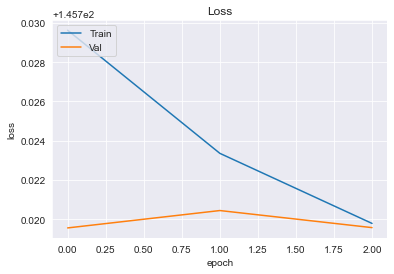

In [72]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc1_loss.pdf")
plt.show()